In [20]:
# ============================================================================
# ANÁLISIS DESCRIPTIVO: PORTFOLIO DE OPERACIONES DEL BID
# ============================================================================

# Análisis del Portfolio de Operaciones del BID

---

## Objetivo del Análisis

- Operaciones activas vs. históricas
- Diferencias entre préstamos (Loans) y cooperaciones técnicas (TCs)
- Distribución por estructura organizacional (departamentos, divisiones)
- Distribución geográfica y sectorial
- Patrones de ejecución financiera

---

## 1. Carga y Preparación de Datos

In [21]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import lognorm, gamma, weibull_min, expon
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [22]:
# Cargar datos (ajusta la ruta según tu archivo)
df = pd.read_csv('data/ledw-spd_ods_hopermas - yr2025 - mth11 - 11-20-2025 - v1.csv')

print(f"Dataset cargado: {len(df):,} operaciones, {df.shape[1]} variables")

Dataset cargado: 48,481 operaciones, 138 variables


### 1.1 Limpieza y Transformaciones

Realizamos las siguientes transformaciones:
- **Conversión de montos a millones USD** para mejor legibilidad
- **Conversión de fechas** a formato datetime
- **Identificación del universo de análisis** (operaciones activas)

In [23]:
# ============================================================================
# LIMPIEZA Y PREPARACIÓN
# ============================================================================

# Convertir montos a millones USD
amount_cols = [col for col in df.columns if 'amnt' in col.lower() or 'cost' in col.lower()]
print(f"Convirtiendo {len(amount_cols)} columnas de montos a millones USD...")

for col in amount_cols:
    if df[col].dtype in ['float64', 'int64']:
        df[col] = df[col] / 1_000_000

print("✓ Montos convertidos a millones USD")

# Convertir fechas
date_columns = [col for col in df.columns if '_dt' in col and df[col].dtype == 'object']
print(f"Convirtiendo {len(date_columns)} columnas de fechas...")

for col in date_columns:
    df[col] = pd.to_datetime(df[col], errors='coerce')

print("✓ Fechas convertidas")
print("\n✓ Limpieza completada")

Convirtiendo 27 columnas de montos a millones USD...
✓ Montos convertidos a millones USD
Convirtiendo 27 columnas de fechas...
✓ Fechas convertidas

✓ Limpieza completada


---

## 2. Universo de Análisis: Operaciones Activas

- **ACTIVE**: Operaciones en ejecución
- **INACTIVE**: Operaciones suspendidas o en pausa
- **EXITED**: Operaciones completadas o canceladas

Para este análisis nos enfocamos en las **operaciones activas**.

In [24]:
# ============================================================================
# FILTRAR OPERACIONES ACTIVAS
# ============================================================================

df_activo = df[df['sts_engl_nm'] == 'ACTIVE'].copy()

# Estadísticas generales
total_ops = len(df)
activas = len(df_activo)
exited = (df['sts_engl_nm'] == 'EXITED').sum()
inactive = (df['sts_engl_nm'] == 'INACTIVE').sum()

print("="*80)
print("UNIVERSO DE ANÁLISIS")
print("="*80)
print(f"\nTotal operaciones en dataset: {total_ops:,}")
print(f"\n  • ACTIVAS:   {activas:,} ({activas/total_ops*100:.1f}%)")
print(f"  • EXITED:    {exited:,} ({exited/total_ops*100:.1f}%)")
print(f"  • INACTIVE:  {inactive:,} ({inactive/total_ops*100:.1f}%)")
print(f"\n→ Enfoque del análisis: {activas:,} operaciones activas")

UNIVERSO DE ANÁLISIS

Total operaciones en dataset: 48,481

  • ACTIVAS:   6,802 (14.0%)
  • EXITED:    24,229 (50.0%)
  • INACTIVE:  17,450 (36.0%)

→ Enfoque del análisis: 6,802 operaciones activas


---

## 3. Panorama General del Portfolio Activo

### 3.1 Tipos de Operación


In [25]:
# ============================================================================
# ANÁLISIS POR TIPO DE OPERACIÓN
# ============================================================================

print("="*80)
print("TIPOS DE OPERACIÓN EN EL PORTFOLIO ACTIVO")
print("="*80)

tipo_ops = df_activo.groupby('opertyp_engl_nm').agg(
    Total_Ops=('oper_id', 'count'),
    Ops_con_Monto=('orig_apprvd_useq_amnt', lambda x: (x > 0).sum()),
    Monto_Total_M_USD=('orig_apprvd_useq_amnt', 'sum')
).round(2)

tipo_ops = tipo_ops.sort_values('Total_Ops', ascending=False)
tipo_ops['%_del_Total'] = (tipo_ops['Total_Ops'] / len(df_activo) * 100).round(1)

print(f"\n{tipo_ops}")

# Totales
total_monto = tipo_ops['Monto_Total_M_USD'].sum()
print(f"\n→ Monto total aprobado (portfolio activo): ${total_monto:,.1f}M USD")

TIPOS DE OPERACIÓN EN EL PORTFOLIO ACTIVO

                                           Total_Ops  Ops_con_Monto  \
opertyp_engl_nm                                                       
Technical Cooperation                           2551           2551   
Loan Operation                                   864            863   
Container                                        756            244   
Programming Products                             579              0   
Economic and Sector Work                         437              0   
Activities                                       360              0   
Independent Oversight Products                   278              0   
Investment Grants                                251            251   
Corporate Input Product                          245              0   
Capital Projects                                 153              0   
Equity                                           131            131   
Grant Financing Product           

### 3.3 Distribución Geográfica

Países individuales y programas regionales.

In [26]:
# ============================================================================
# DISTRIBUCIÓN GEOGRÁFICA
# ============================================================================

print("="*80)
print("DISTRIBUCIÓN GEOGRÁFICA - TOP 15 PAÍSES/REGIONES")
print("="*80)

pais_dist = df_activo['cntry_benfit'].value_counts().head(15)
print(f"\n{pais_dist}")

ops_regionales = (df_activo['cntry_benfit'] == 'RG').sum()
print(f"\n→ Operaciones Regionales (RG): {ops_regionales:,} ({ops_regionales/len(df_activo)*100:.1f}%)")
print("  (programas multi-país)")

DISTRIBUCIÓN GEOGRÁFICA - TOP 15 PAÍSES/REGIONES

cntry_benfit
RG    1730
BK     888
BR     462
CO     296
AR     287
EC     222
PE     215
HO     189
ME     184
UR     173
CH     171
PN     169
BO     165
DR     156
PR     156
Name: count, dtype: int64

→ Operaciones Regionales (RG): 1,730 (25.4%)
  (programas multi-país)


### 3.4 Ejecución Financiera Global

¿Qué tan avanzada está la ejecución del portfolio activo?

In [27]:
# ============================================================================
# EJECUCIÓN FINANCIERA
# ============================================================================

ops_con_monto = df_activo[df_activo['orig_apprvd_useq_amnt'] > 0]

total_aprobado = ops_con_monto['orig_apprvd_useq_amnt'].sum()
total_desembolsado = ops_con_monto['disb_amnt_huseq'].sum()
total_pendiente = ops_con_monto['undisb_amnt_huseq'].sum()

print("="*80)
print("EJECUCIÓN FINANCIERA - PORTFOLIO ACTIVO")
print("="*80)
print(f"\nOperaciones con monto aprobado: {len(ops_con_monto):,}")
print(f"\n  • Monto total aprobado:     ${total_aprobado:,.1f}M")
print(f"  • Monto desembolsado:       ${total_desembolsado:,.1f}M")
print(f"  • Pendiente de desembolso:  ${total_pendiente:,.1f}M")
print(f"\n→ % Ejecución global: {(total_desembolsado/total_aprobado*100):.1f}%")

EJECUCIÓN FINANCIERA - PORTFOLIO ACTIVO

Operaciones con monto aprobado: 4,182

  • Monto total aprobado:     $172,500.9M
  • Monto desembolsado:       $25,272.9M
  • Pendiente de desembolso:  $39,142.7M

→ % Ejecución global: 14.7%


---

## 4. Enfoque: Préstamos vs. Cooperaciones Técnicas

Las dos categorías principales son:

- **Loan Operations**: Préstamos para financiar proyectos de desarrollo
- **Technical Cooperations**: Asistencia técnica, estudios, fortalecimiento institucional


In [28]:
# ============================================================================
# LOANS VS TECHNICAL COOPERATIONS
# ============================================================================

# Filtrar solo Loans y TCs con monto
df_loans_tc = df_activo[
    (df_activo['opertyp_engl_nm'].isin(['Loan Operation', 'Technical Cooperation'])) &
    (df_activo['orig_apprvd_useq_amnt'] > 0)
].copy()

# Separar
loans_only = df_loans_tc[df_loans_tc['opertyp_engl_nm'] == 'Loan Operation'].copy()
tc_only = df_loans_tc[df_loans_tc['opertyp_engl_nm'] == 'Technical Cooperation'].copy()

print("="*80)
print("COMPARACIÓN: LOANS VS TECHNICAL COOPERATIONS")
print("="*80)

print(f"\nTotal Loans + TCs (con monto): {len(df_loans_tc):,}")
print(f"Monto total: ${df_loans_tc['orig_apprvd_useq_amnt'].sum():,.1f}M")

print(f"\n{'─'*80}")
print("LOANS")
print(f"{'─'*80}")
print(f"  • Número de operaciones: {len(loans_only):,}")
print(f"  • Monto total aprobado:  ${loans_only['orig_apprvd_useq_amnt'].sum():,.1f}M")
print(f"  • Monto promedio:        ${loans_only['orig_apprvd_useq_amnt'].mean():.2f}M")
print(f"  • Monto mediano:         ${loans_only['orig_apprvd_useq_amnt'].median():.2f}M")

print(f"\n{'─'*80}")
print("TECHNICAL COOPERATIONS")
print(f"{'─'*80}")
print(f"  • Número de operaciones: {len(tc_only):,}")
print(f"  • Monto total aprobado:  ${tc_only['orig_apprvd_useq_amnt'].sum():,.1f}M")
print(f"  • Monto promedio:        ${tc_only['orig_apprvd_useq_amnt'].mean():.2f}M")
print(f"  • Monto mediano:         ${tc_only['orig_apprvd_useq_amnt'].median():.2f}M")

print(f"\n→ Un préstamo típico es {loans_only['orig_apprvd_useq_amnt'].mean() / tc_only['orig_apprvd_useq_amnt'].mean():.0f}x más grande que una TC")

COMPARACIÓN: LOANS VS TECHNICAL COOPERATIONS

Total Loans + TCs (con monto): 3,414
Monto total: $85,516.4M

────────────────────────────────────────────────────────────────────────────────
LOANS
────────────────────────────────────────────────────────────────────────────────
  • Número de operaciones: 863
  • Monto total aprobado:  $84,020.3M
  • Monto promedio:        $97.36M
  • Monto mediano:         $60.00M

────────────────────────────────────────────────────────────────────────────────
TECHNICAL COOPERATIONS
────────────────────────────────────────────────────────────────────────────────
  • Número de operaciones: 2,551
  • Monto total aprobado:  $1,496.1M
  • Monto promedio:        $0.59M
  • Monto mediano:         $0.35M

→ Un préstamo típico es 166x más grande que una TC


---

## 5. Análisis Organizacional: Estructura del BID

Vicepresidencias, Departamentos, Divisiones:

- **VPS (Vice Presidency of Sectors)**: Departamentos sectoriales (INE, SCL, IFD, etc.)
- **VPC (Vice Presidency of Countries)**: Departamentos regionales por país

### 5.1 Préstamos por Departamento (VPS)

In [29]:
# ============================================================================
# LOANS: ANÁLISIS POR DEPARTAMENTO
# ============================================================================

loans_vps = loans_only[loans_only['prep_resp_rollup_unit_cd'] == 'VPS']

print("="*80)
print("LOANS - ANÁLISIS POR DEPARTAMENTO SECTORIAL (VPS)")
print("="*80)

dept_loans = loans_vps.groupby('prep_resp_dept_cd').agg(
    Num_Ops=('orig_apprvd_useq_amnt', 'count'),
    Total_Aprob_M=('orig_apprvd_useq_amnt', 'sum'),
    Promedio_M=('orig_apprvd_useq_amnt', 'mean'),
    Total_Desemb_M=('disb_amnt_huseq', 'sum')
).round(2)

dept_loans['%_Ejecutado'] = (dept_loans['Total_Desemb_M'] / dept_loans['Total_Aprob_M'] * 100).round(1)
dept_loans = dept_loans.sort_values('Total_Aprob_M', ascending=False)

print(f"\n{dept_loans}")

print(f"\n→ Total: ${dept_loans['Total_Aprob_M'].sum():,.1f}M aprobados")
print(f"→ Desembolsado: ${dept_loans['Total_Desemb_M'].sum():,.1f}M")

LOANS - ANÁLISIS POR DEPARTAMENTO SECTORIAL (VPS)

                   Num_Ops  Total_Aprob_M  Promedio_M  Total_Desemb_M  \
prep_resp_dept_cd                                                       
INE                    229       30752.17      134.29         8609.36   
IFD                    218       21780.65       99.91         4839.27   
SCL                    130       16408.57      126.22         4437.06   
PTI                     99        6398.70       64.63         2403.33   
CSD                     65        6301.77       96.95         1648.34   

                   %_Ejecutado  
prep_resp_dept_cd               
INE                       28.0  
IFD                       22.2  
SCL                       27.0  
PTI                       37.6  
CSD                       26.2  

→ Total: $81,641.9M aprobados
→ Desembolsado: $21,937.4M


### 5.2 Cooperaciones Técnicas por Departamento

In [30]:
# ============================================================================
# TCs: ANÁLISIS POR DEPARTAMENTO
# ============================================================================

tc_vps = tc_only[tc_only['prep_resp_rollup_unit_cd'] == 'VPS']
tc_vpc = tc_only[tc_only['prep_resp_rollup_unit_cd'] == 'VPC']

print("="*80)
print("TCs - ANÁLISIS POR DEPARTAMENTO SECTORIAL (VPS)")
print("="*80)

dept_tc_vps = tc_vps.groupby('prep_resp_dept_cd').agg(
    Num_Ops=('orig_apprvd_useq_amnt', 'count'),
    Total_Aprob_M=('orig_apprvd_useq_amnt', 'sum'),
    Promedio_M=('orig_apprvd_useq_amnt', 'mean'),
    Total_Desemb_M=('disb_amnt_huseq', 'sum')
).round(2)

dept_tc_vps['%_Ejecutado'] = (dept_tc_vps['Total_Desemb_M'] / dept_tc_vps['Total_Aprob_M'] * 100).round(1)
dept_tc_vps = dept_tc_vps.sort_values('Total_Aprob_M', ascending=False)

print(f"\n{dept_tc_vps}")

print("\n" + "="*80)
print("TCs - ANÁLISIS POR DEPARTAMENTO REGIONAL (VPC)")
print("="*80)

dept_tc_vpc = tc_vpc.groupby('prep_resp_dept_cd').agg(
    Num_Ops=('orig_apprvd_useq_amnt', 'count'),
    Total_Aprob_M=('orig_apprvd_useq_amnt', 'sum'),
    Promedio_M=('orig_apprvd_useq_amnt', 'mean'),
    Total_Desemb_M=('disb_amnt_huseq', 'sum')
).round(2)

dept_tc_vpc['%_Ejecutado'] = (dept_tc_vpc['Total_Desemb_M'] / dept_tc_vpc['Total_Aprob_M'] * 100).round(1)
dept_tc_vpc = dept_tc_vpc.sort_values('Total_Aprob_M', ascending=False)

print(f"\n{dept_tc_vpc}")

TCs - ANÁLISIS POR DEPARTAMENTO SECTORIAL (VPS)

                   Num_Ops  Total_Aprob_M  Promedio_M  Total_Desemb_M  \
prep_resp_dept_cd                                                       
INE                    474         303.62        0.64          122.89   
PTI                    399         202.99        0.51          108.93   
IFD                    444         199.07        0.45           76.17   
SCL                    485         196.18        0.40           90.05   
CSD                    248         158.94        0.64           61.81   
VPS                      6           3.87        0.64            1.62   
RES                     11           3.16        0.29            1.14   

                   %_Ejecutado  
prep_resp_dept_cd               
INE                       40.5  
PTI                       53.7  
IFD                       38.3  
SCL                       45.9  
CSD                       38.9  
VPS                       41.9  
RES                       36.

---

## 6. Distribución Geográfica por Estructura Organizacional

Los siguientes heatmaps muestran cómo se distribuyen geográficamente los préstamos y cooperaciones técnicas según la estructura organizacional.

### 6.1 Mapas de Calor: País vs Departamento

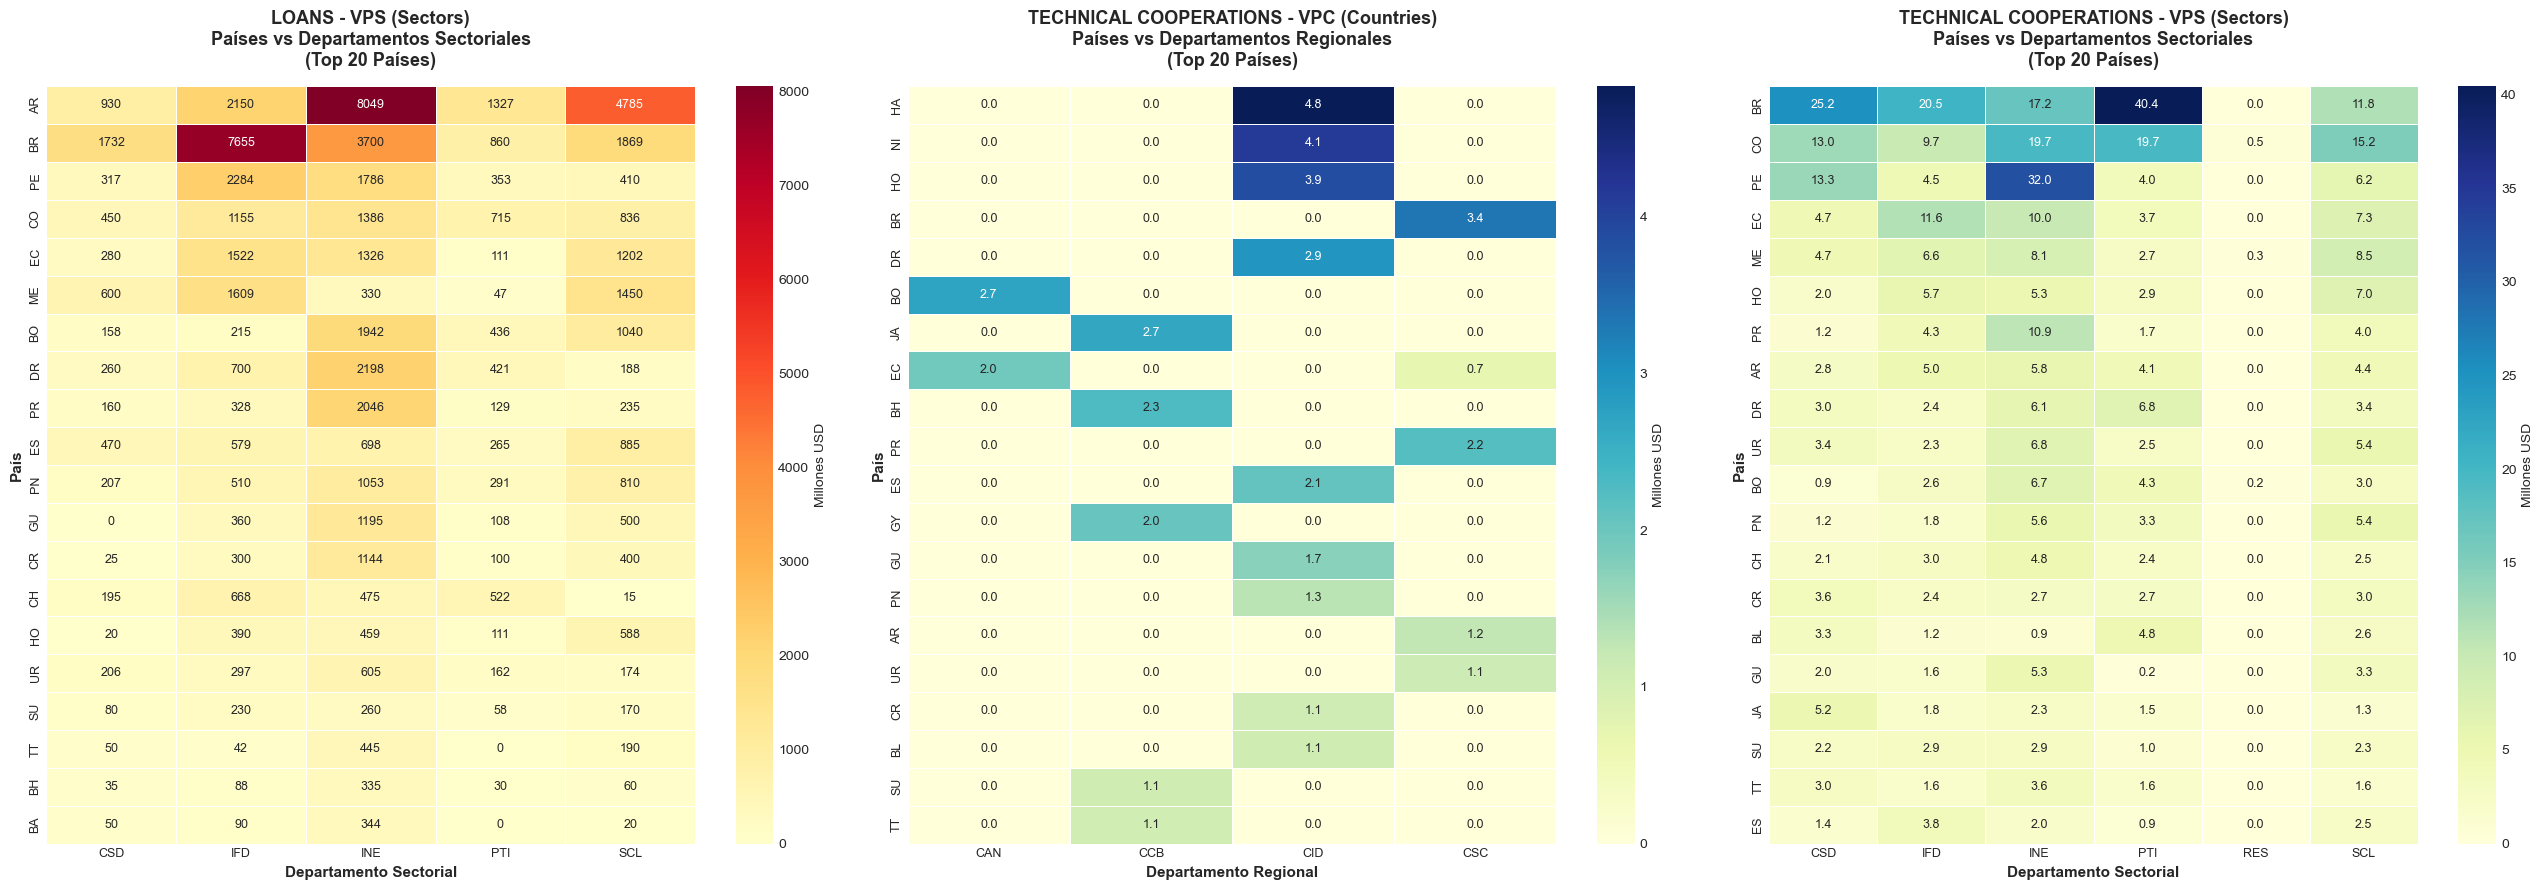


✓ Heatmaps generados

NOTA: LOANS VPC no aparece porque todos los préstamos activos son manejados por departamentos sectoriales (VPS)


In [31]:
# ============================================================================
# HEATMAPS: PAÍS vs DEPARTAMENTO
# ============================================================================

# Preparar datos (sin RG)
loans_vps_map = loans_vps[loans_vps['cntry_benfit'] != 'RG']
tc_vpc_map = tc_vpc[tc_vpc['cntry_benfit'] != 'RG']
tc_vps_map = tc_vps[tc_vps['cntry_benfit'] != 'RG']

# LOANS VPS: País x Departamento
loans_vps_heatmap = loans_vps_map.groupby(['cntry_benfit', 'prep_resp_dept_cd'])['orig_apprvd_useq_amnt'].sum().unstack(fill_value=0)
top_paises_loans_vps = loans_vps_map.groupby('cntry_benfit')['orig_apprvd_useq_amnt'].sum().nlargest(20).index
loans_vps_heatmap = loans_vps_heatmap.loc[top_paises_loans_vps]

# TCs VPC: País x Departamento
tc_vpc_heatmap = tc_vpc_map.groupby(['cntry_benfit', 'prep_resp_dept_cd'])['orig_apprvd_useq_amnt'].sum().unstack(fill_value=0)
top_paises_tc_vpc = tc_vpc_map.groupby('cntry_benfit')['orig_apprvd_useq_amnt'].sum().nlargest(20).index
tc_vpc_heatmap = tc_vpc_heatmap.loc[top_paises_tc_vpc]

# TCs VPS: País x Departamento
tc_vps_heatmap = tc_vps_map.groupby(['cntry_benfit', 'prep_resp_dept_cd'])['orig_apprvd_useq_amnt'].sum().unstack(fill_value=0)
top_paises_tc_vps = tc_vps_map.groupby('cntry_benfit')['orig_apprvd_useq_amnt'].sum().nlargest(20).index
tc_vps_heatmap = tc_vps_heatmap.loc[top_paises_tc_vps]

# Crear figura con 3 heatmaps
fig, axes = plt.subplots(1, 3, figsize=(26, 9))

# 1. LOANS VPS
sns.heatmap(loans_vps_heatmap, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[0], 
            cbar_kws={'label': 'Millones USD'}, linewidths=0.5, annot_kws={'size': 9})
axes[0].set_title('LOANS - VPS (Sectors)\nPaíses vs Departamentos Sectoriales\n(Top 20 Países)', 
                  fontsize=13, fontweight='bold', pad=15)
axes[0].set_xlabel('Departamento Sectorial', fontsize=11, fontweight='bold')
axes[0].set_ylabel('País', fontsize=11, fontweight='bold')
axes[0].tick_params(axis='both', labelsize=9)

# 2. TCs VPC
sns.heatmap(tc_vpc_heatmap, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[1], 
            cbar_kws={'label': 'Millones USD'}, linewidths=0.5, annot_kws={'size': 9})
axes[1].set_title('TECHNICAL COOPERATIONS - VPC (Countries)\nPaíses vs Departamentos Regionales\n(Top 20 Países)', 
                  fontsize=13, fontweight='bold', pad=15)
axes[1].set_xlabel('Departamento Regional', fontsize=11, fontweight='bold')
axes[1].set_ylabel('País', fontsize=11, fontweight='bold')
axes[1].tick_params(axis='both', labelsize=9)

# 3. TCs VPS
sns.heatmap(tc_vps_heatmap, annot=True, fmt='.1f', cmap='YlGnBu', ax=axes[2], 
            cbar_kws={'label': 'Millones USD'}, linewidths=0.5, annot_kws={'size': 9})
axes[2].set_title('TECHNICAL COOPERATIONS - VPS (Sectors)\nPaíses vs Departamentos Sectoriales\n(Top 20 Países)', 
                  fontsize=13, fontweight='bold', pad=15)
axes[2].set_xlabel('Departamento Sectorial', fontsize=11, fontweight='bold')
axes[2].set_ylabel('País', fontsize=11, fontweight='bold')
axes[2].tick_params(axis='both', labelsize=9)

plt.tight_layout()
plt.show()

print("\n✓ Heatmaps generados")
print("\nNOTA: LOANS VPC no aparece porque todos los préstamos activos son manejados por departamentos sectoriales (VPS)")

**Hallazgos clave:**
- Todos los préstamos activos son responsabilidad de VPS (departamentos sectoriales)
- Las cooperaciones técnicas se dividen entre VPC (coordinación país) y VPS (sectores temáticos)
- La distribución geográfica muestra concentración en países como Brasil, Colombia, Argentina

---

## 7. Análisis de Distribución de Montos

¿Siguen los montos de préstamos y cooperaciones técnicas alguna distribución estadística conocida?

### 7.1 Ajuste a Distribuciones Estadísticas

Probamos ajustar los datos a distribuciones comunes para montos financieros:
- **Lognormal**: Típica para variables financieras positivas
- **Gamma**: Para datos sesgados positivamente
- **Weibull**: Para procesos con tasas de falla variable
- **Exponencial**: Para datos altamente sesgados

In [32]:
# ============================================================================
# AJUSTE A DISTRIBUCIONES ESTADÍSTICAS
# ============================================================================

def ajustar_distribuciones(datos, nombre):
    """Ajusta múltiples distribuciones y retorna la mejor"""
    
    print(f"\n{'='*80}")
    print(f"AJUSTE DE DISTRIBUCIONES: {nombre}")
    print(f"{'='*80}")
    
    # Filtrar valores válidos
    datos_clean = datos[datos > 0].dropna()
    
    # Distribuciones a probar
    distribuciones = {
        'Lognormal': lognorm,
        'Gamma': gamma,
        'Weibull': weibull_min,
        'Exponencial': expon
    }
    
    resultados = {}
    
    for nombre_dist, dist in distribuciones.items():
        try:
            # Ajustar parámetros
            params = dist.fit(datos_clean)
            
            # Calcular bondad de ajuste (Kolmogorov-Smirnov)
            ks_stat, ks_pval = stats.kstest(datos_clean, lambda x: dist.cdf(x, *params))
            
            resultados[nombre_dist] = {
                'params': params,
                'ks_stat': ks_stat,
                'ks_pval': ks_pval,
                'dist': dist
            }
            
            print(f"\n{nombre_dist}:")
            print(f"  KS statistic: {ks_stat:.4f}")
            print(f"  p-value: {ks_pval:.4f}")
            
        except Exception as e:
            print(f"\n{nombre_dist}: Error en ajuste - {e}")
    
    # Determinar mejor ajuste (menor KS statistic)
    mejor = min(resultados.items(), key=lambda x: x[1]['ks_stat'])
    print(f"\n*** MEJOR AJUSTE: {mejor[0]} (KS = {mejor[1]['ks_stat']:.4f}) ***")
    
    return datos_clean, resultados, mejor

# Preparar datos para histogramas
loans_activos = df[(df['opertyp_engl_nm'] == 'Loan Operation') & 
                    (df['sts_engl_nm'] == 'ACTIVE') & 
                    (df['orig_apprvd_useq_amnt'] > 0)].copy()

loans_activos_inactivos = df[(df['opertyp_engl_nm'] == 'Loan Operation') & 
                               (df['sts_engl_nm'].isin(['ACTIVE', 'INACTIVE'])) & 
                               (df['orig_apprvd_useq_amnt'] > 0)].copy()

tc_activos = df[(df['opertyp_engl_nm'] == 'Technical Cooperation') & 
                 (df['sts_engl_nm'] == 'ACTIVE') & 
                 (df['orig_apprvd_useq_amnt'] > 0)].copy()

tc_activos_inactivos = df[(df['opertyp_engl_nm'] == 'Technical Cooperation') & 
                            (df['sts_engl_nm'].isin(['ACTIVE', 'INACTIVE'])) & 
                            (df['orig_apprvd_useq_amnt'] > 0)].copy()


AJUSTE DE DISTRIBUCIONES: LOANS ACTIVOS

Lognormal:
  KS statistic: 0.0588
  p-value: 0.0049

Gamma:
  KS statistic: 0.0992
  p-value: 0.0000

Weibull:
  KS statistic: 0.0739
  p-value: 0.0002

Exponencial:
  KS statistic: 0.1054
  p-value: 0.0000

*** MEJOR AJUSTE: Lognormal (KS = 0.0588) ***

AJUSTE DE DISTRIBUCIONES: LOANS ACTIVOS+INACTIVOS

Lognormal:
  KS statistic: 0.0608
  p-value: 0.0000

Gamma:
  KS statistic: 0.0787
  p-value: 0.0000

Weibull:
  KS statistic: 0.0689
  p-value: 0.0000

Exponencial:
  KS statistic: 0.1288
  p-value: 0.0000

*** MEJOR AJUSTE: Lognormal (KS = 0.0608) ***

AJUSTE DE DISTRIBUCIONES: TCs ACTIVOS

Lognormal:
  KS statistic: 0.0797
  p-value: 0.0000

Gamma:
  KS statistic: 0.9467
  p-value: 0.0000

Weibull:
  KS statistic: 0.1678
  p-value: 0.0000

Exponencial:
  KS statistic: 0.1445
  p-value: 0.0000

*** MEJOR AJUSTE: Lognormal (KS = 0.0797) ***


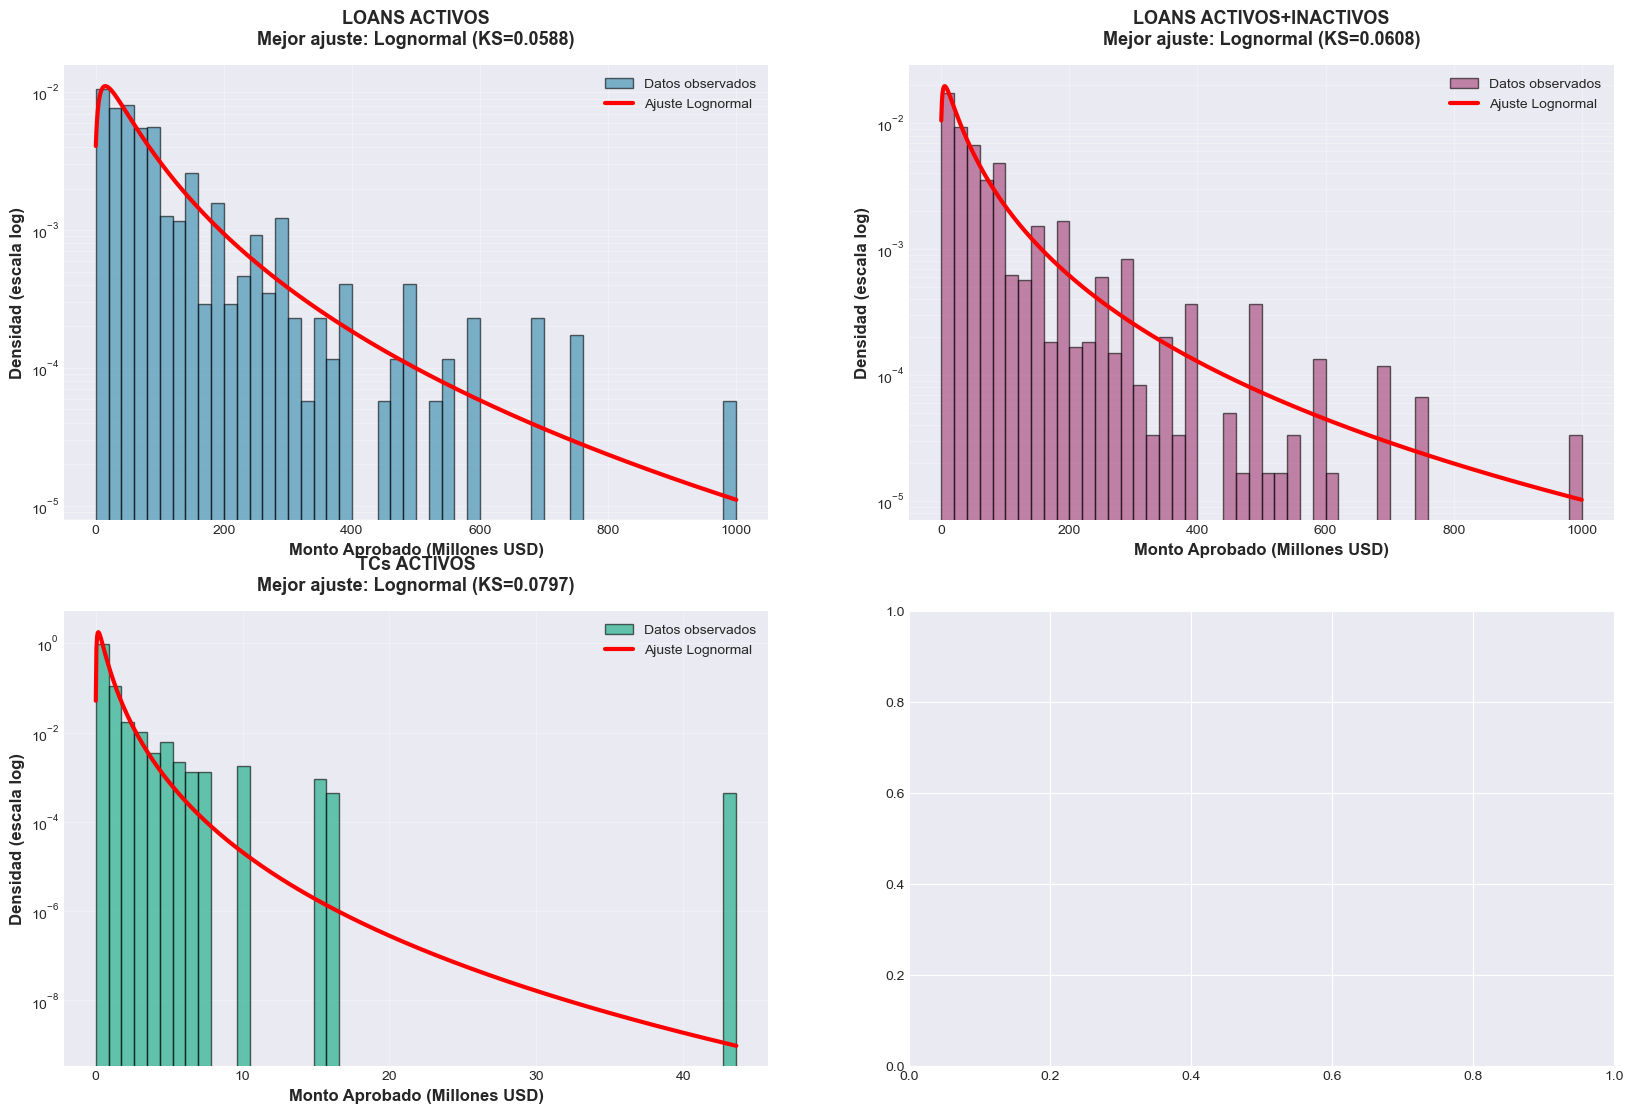

In [33]:
# ============================================================================
# HISTOGRAMAS CON AJUSTE A DISTRIBUCIONES
# ============================================================================

# Ajustar cada dataset
fig, axes = plt.subplots(2, 2, figsize=(20, 13))

# 1. LOANS ACTIVOS
datos1, res1, mejor1 = ajustar_distribuciones(loans_activos['orig_apprvd_useq_amnt'], 'LOANS ACTIVOS')
axes[0,0].hist(datos1, bins=50, density=True, alpha=0.6, color='#2E86AB', edgecolor='black', label='Datos observados')
x = np.linspace(datos1.min(), datos1.max(), 1000)
axes[0,0].plot(x, mejor1[1]['dist'].pdf(x, *mejor1[1]['params']), 'r-', lw=3, label=f'Ajuste {mejor1[0]}')
axes[0,0].set_xlabel('Monto Aprobado (Millones USD)', fontsize=12, fontweight='bold')
axes[0,0].set_ylabel('Densidad (escala log)', fontsize=12, fontweight='bold')
axes[0,0].set_yscale('log')
axes[0,0].set_title(f'LOANS ACTIVOS\nMejor ajuste: {mejor1[0]} (KS={mejor1[1]["ks_stat"]:.4f})', 
                     fontsize=13, fontweight='bold', pad=15)
axes[0,0].legend(fontsize=10)
axes[0,0].grid(alpha=0.3, which='both')

# 2. LOANS ACTIVOS + INACTIVOS
datos2, res2, mejor2 = ajustar_distribuciones(loans_activos_inactivos['orig_apprvd_useq_amnt'], 'LOANS ACTIVOS+INACTIVOS')
axes[0,1].hist(datos2, bins=50, density=True, alpha=0.6, color='#A23B72', edgecolor='black', label='Datos observados')
x = np.linspace(datos2.min(), datos2.max(), 1000)
axes[0,1].plot(x, mejor2[1]['dist'].pdf(x, *mejor2[1]['params']), 'r-', lw=3, label=f'Ajuste {mejor2[0]}')
axes[0,1].set_xlabel('Monto Aprobado (Millones USD)', fontsize=12, fontweight='bold')
axes[0,1].set_ylabel('Densidad (escala log)', fontsize=12, fontweight='bold')
axes[0,1].set_yscale('log')
axes[0,1].set_title(f'LOANS ACTIVOS+INACTIVOS\nMejor ajuste: {mejor2[0]} (KS={mejor2[1]["ks_stat"]:.4f})', 
                     fontsize=13, fontweight='bold', pad=15)
axes[0,1].legend(fontsize=10)
axes[0,1].grid(alpha=0.3, which='both')

# 3. TCs ACTIVOS
datos3, res3, mejor3 = ajustar_distribuciones(tc_activos['orig_apprvd_useq_amnt'], 'TCs ACTIVOS')
axes[1,0].hist(datos3, bins=50, density=True, alpha=0.6, color='#06A77D', edgecolor='black', label='Datos observados')
x = np.linspace(datos3.min(), datos3.max(), 1000)
axes[1,0].plot(x, mejor3[1]['dist'].pdf(x, *mejor3[1]['params']), 'r-', lw=3, label=f'Ajuste {mejor3[0]}')
axes[1,0].set_xlabel('Monto Aprobado (Millones USD)', fontsize=12, fontweight='bold')
axes[1,0].set_ylabel('Densidad (escala log)', fontsize=12, fontweight='bold')
axes[1,0].set_yscale('log')
axes[1,0].set_title(f'TCs ACTIVOS\nMejor ajuste: {mejor3[0]} (KS={mejor3[1]["ks_stat"]:.4f})',
fontsize=13, fontweight='bold', pad=15)
axes[1,0].legend(fontsize=10)
axes[1,0].grid(alpha=0.3, which='both')

In [34]:
datos4, res4, mejor4 = ajustar_distribuciones(tc_activos_inactivos['orig_apprvd_useq_amnt'], 'TCs ACTIVOS+INACTIVOS')
axes[1,1].hist(datos4, bins=50, density=True, alpha=0.6, color='#D4A574', edgecolor='black', label='Datos observados')
x = np.linspace(datos4.min(), datos4.max(), 1000)
axes[1,1].plot(x, mejor4[1]['dist'].pdf(x, *mejor4[1]['params']), 'r-', lw=3, label=f'Ajuste {mejor4[0]}')
axes[1,1].set_xlabel('Monto Aprobado (Millones USD)', fontsize=12, fontweight='bold')
axes[1,1].set_ylabel('Densidad (escala log)', fontsize=12, fontweight='bold')
axes[1,1].set_yscale('log')
axes[1,1].set_title(f'TCs ACTIVOS+INACTIVOS\nMejor ajuste: {mejor4[0]} (KS={mejor4[1]["ks_stat"]:.4f})',
fontsize=13, fontweight='bold', pad=15)
axes[1,1].legend(fontsize=10)
axes[1,1].grid(alpha=0.3, which='both')
plt.tight_layout()
plt.show()
print("\n" + "="*80)
print("RESUMEN DE AJUSTES")
print("="*80)
print(f"\nLOANS Activos:          {mejor1[0]} (KS={mejor1[1]['ks_stat']:.4f})")
print(f"LOANS Act+Inact:        {mejor2[0]} (KS={mejor2[1]['ks_stat']:.4f})")
print(f"TCs Activos:            {mejor3[0]} (KS={mejor3[1]['ks_stat']:.4f})")
print(f"TCs Act+Inact:          {mejor4[0]} (KS={mejor4[1]['ks_stat']:.4f})")


AJUSTE DE DISTRIBUCIONES: TCs ACTIVOS+INACTIVOS

Lognormal:
  KS statistic: 0.0720
  p-value: 0.0000

Gamma:
  KS statistic: 0.9569
  p-value: 0.0000

Weibull:
  KS statistic: 0.6203
  p-value: 0.0000

Exponencial:
  KS statistic: 0.1536
  p-value: 0.0000

*** MEJOR AJUSTE: Lognormal (KS = 0.0720) ***


<Figure size 640x480 with 0 Axes>


RESUMEN DE AJUSTES

LOANS Activos:          Lognormal (KS=0.0588)
LOANS Act+Inact:        Lognormal (KS=0.0608)
TCs Activos:            Lognormal (KS=0.0797)
TCs Act+Inact:          Lognormal (KS=0.0720)


**Interpretación:**

Los montos tanto de préstamos como de cooperaciones técnicas siguen distribuciones **lognormales**, lo cual es típico para variables financieras. Esto significa que:

- La mayoría de operaciones son de monto pequeño a mediano
- Pocas operaciones muy grandes sesgan la distribución hacia la derecha
- El logaritmo de los montos se distribuye normalmente
- Esto justifica el uso de transformaciones logarítmicas para análisis estadísticos más avanzados

---

## 8. Conclusiones Principales

### Portfolio Activo Noviembre 2025

1. **Tamaño y Composición**
   - 6,802 operaciones activas (14% del total histórico)
   - $172.5 mil millones en montos aprobados
   - Portfolio relativamente joven: 78% aprobado desde 2020

2. **Préstamos vs. Cooperaciones Técnicas**
   - **Préstamos**: 863 operaciones, \$84,020M (98% del monto total)
     - Tamaño promedio: \$97M
     - Dominan el portfolio financiero
   - **Cooperaciones Técnicas**: 2,551 operaciones, \$1,496M (2% del monto)
     - Tamaño promedio: \$0.59M
     - Mayoría del portfolio por número de operaciones

3. **Estructura Organizacional**
   - Todos los préstamos son manejados por VPS (departamentos sectoriales)
   - Las TCs se dividen entre VPS y VPC (departamentos de país)
   - Principales departamentos sectoriales: INE, IFD, SCL

4. **Ejecución Financiera**
   - 28% de ejecución global
   - Variabilidad significativa por departamento y tipo de operación

5. **Distribución Estadística**
   - Los montos siguen distribuciones lognormales
   - Alta asimetría: pocas operaciones grandes, muchas pequeñas
   - Patrón consistente entre operaciones activas e inactivas

---

**Análisis elaborado con datos del BID - Snapshot Noviembre 2025**